In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 11:01:32 2022

@author: Simone
"""

import numpy as np 
import pandas as pd 
from IPython.display import display
#from random import randrange
#import random
#import sklearn
#%matplotlib inline
# import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib notebook
pop = pd.read_csv("new/popSessoEtaLngLatSize2021.csv", dtype = {"ITTER107":str})
pop

,ITTER107,Territorio,Sesso,Età,Value,lng,lat,Size km2
0,1272,Torino,maschi,0 anni,2900,7.680687,45.073274,130.17
1,1272,Torino,femmine,0 anni,2724,7.680687,45.073274,130.17
2,1272,Torino,totale,0 anni,5624,7.680687,45.073274,130.17
3,1272,Torino,femmine,1 anni,2890,7.680687,45.073274,130.17
4,1272,Torino,maschi,1 anni,3015,7.680687,45.073274,130.17
...,...,...,...,...,...,...,...,...
2460235,IT111,Sud Sardegna,maschi,25 anni,1585,NaN,NaN,NaN
2460236,IT111,Sud Sardegna,femmine,91 anni,720,NaN,NaN,NaN
2460237,IT111,Sud Sardegna,femmine,23 anni,1330,NaN,NaN,NaN
2460238,IT111,Sud Sardegna,maschi,totale,169114,NaN,NaN,NaN


## Preprocessing

#### Get marital status

In [2]:
mar =  pd.read_csv("new/maritalStatus2020Agg2021.csv", dtype = {"ITTER107":str})
mar['ITTER107'] = mar['ITTER107'].str.lstrip('0')
mar = mar.astype({"Value": int})
mar

,ITTER107,Territorio,Sesso,Età,Stato civile,Value
0,IT,Italia,maschi,0 anni,nubile/celibe,212756
1,IT,Italia,maschi,0 anni,totale,212756
2,IT,Italia,femmine,0 anni,nubile/celibe,202218
3,IT,Italia,femmine,0 anni,totale,202218
4,IT,Italia,totale,0 anni,nubile/celibe,414974
...,...,...,...,...,...,...
11143435,41044,Pesaro,totale,totale,coniugata/o,44776
11143436,41044,Pesaro,totale,totale,divorziata/o,4109
11143437,41044,Pesaro,totale,totale,nubile/celibe,40387
11143438,41044,Pesaro,totale,totale,totale,96786


In [3]:
tot = pd.merge(pop, mar,how='outer',left_on=['ITTER107','Territorio','Sesso','Età'],right_on=['ITTER107','Territorio','Sesso','Età'],indicator=True)

In [4]:
tot = tot.drop(['Value_x','_merge'], axis=1)
tot= tot.rename(columns={'Value_y': 'Value'})
tot

,ITTER107,Territorio,Sesso,Età,lng,lat,Size km2,Stato civile,Value
0,1272,Torino,maschi,0 anni,7.680687,45.073274,130.17,nubile/celibe,3030
1,1272,Torino,maschi,0 anni,7.680687,45.073274,130.17,totale,3030
2,1272,Torino,femmine,0 anni,7.680687,45.073274,130.17,nubile/celibe,2905
3,1272,Torino,femmine,0 anni,7.680687,45.073274,130.17,totale,2905
4,1272,Torino,totale,0 anni,7.680687,45.073274,130.17,nubile/celibe,5935
...,...,...,...,...,...,...,...,...,...
11143435,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,totale,2901
11143436,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,divorziata/o,3
11143437,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,coniugata/o,5
11143438,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,nubile/celibe,2893


In [5]:
tot = tot.loc[tot['ITTER107'].str.isdigit()] #No areas
tot = tot.loc[tot['Età'] != "totale"]
tot = tot.loc[tot['Sesso'] != "totale"]
tot = tot.loc[tot['Stato civile'] != "totale"]
try:
    tot['Età'] = tot['Età'].map(lambda x: x.rstrip(' anni'))
    tot['Età'] = tot['Età'].map(lambda x: x.rstrip(' anni e più'))
except:
    print("Already done")
tot['Età'] = tot['Età'].astype(int)
tot["ITTER107"] = pd.to_numeric(tot["ITTER107"]) #Can do because no areas

## Get only Lombardy

In [6]:
# lombardy = pd.read_excel('new/Elenco-comuni-italiani.xls', sheet_name=0) #reads the first sheet of your excel file
# lombardy = lombardy[lombardy['Denominazione Regione']=='Lombardia'] #Filtering dataframe
# tot = pd.merge(tot, lombardy,how='inner',left_on=['ITTER107'],right_on=['Codice Comune formato alfanumerico']).drop(lombardy.columns,axis = 1)
# tot

#### Create age groups and popul/km2

In [7]:
bins= [0,3,13,20,30,40,50,60,70,80,90,100,110]
labels = ['Infant','Kid','Teen','Young adult','30s','40s','50s','60s','70s','80s','90s','100s or older']
tot['AgeGroup'] = pd.cut(tot['Età'], bins=bins, labels=labels, right=False) ##Create age groups
 #Sum population for age group, city and gender
tot = tot.loc[tot['AgeGroup'] == "30s"]
tot = tot.loc[tot['Sesso'] == "maschi"]
tot = tot.loc[tot['Stato civile'] == "coniugata/o"]

#Gropu by age group
df = tot.groupby(['Territorio','Sesso'], as_index=False).agg({'Value':'sum','lat': 'first','lng':'first', 'Size km2':'first'})#["Value"].apply(lambda x : x.astype(int).sum()).to_frame(name = 'Value').reset_index()
df['populPerKm2'] = df['Value']/df['Size km2']
df = df.loc[df['populPerKm2'] > 10]
df

,Territorio,Sesso,Value,lat,lng,Size km2,populPerKm2
0,Abano Terme,maschi,275,45.359387,11.788713,21.57,12.749189
6,Abbiategrasso,maschi,576,45.398576,8.917486,47.10,12.229299
17,Acerra,maschi,2139,40.945864,14.371184,54.08,39.552515
18,Aci Bonaccorsi,maschi,94,37.597894,15.108607,1.70,55.294118
19,Aci Castello,maschi,384,37.555818,15.145233,8.65,44.393064
...,...,...,...,...,...,...,...
7851,Zagarolo,maschi,407,41.839865,12.829638,28.97,14.049016
7854,Zanica,maschi,237,45.641956,9.680974,14.66,16.166439
7855,Zanè,maschi,155,45.720613,11.454076,7.64,20.287958
7870,Zermeghedo,maschi,47,45.475435,11.368894,2.97,15.824916


## Clustering

In [8]:
# X = StandardScaler().fit_transform(df[['Value','lng','lat']])
ss = StandardScaler()
X = ss.fit_transform(df[['lng','lat']]) #'populPerKm2' per avere cluster di popolazione simile (non voluta)
#clustering = DBSCAN(eps=0.1, min_samples=10).fit(X)
km = KMeans(n_clusters=15,init = 'k-means++', random_state=0, max_iter = 1000)#15
clustering = km.fit(X)
np.unique(clustering.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [9]:
# Extract the data we're interested in
lat = df['lat'].values
lon = df['lng'].values
population = df['Value'].values
populationsqm = df['populPerKm2'].values
#area = cities['area_total_km2'].values

## 3D map Italy

<IPython.core.display.Javascript object>


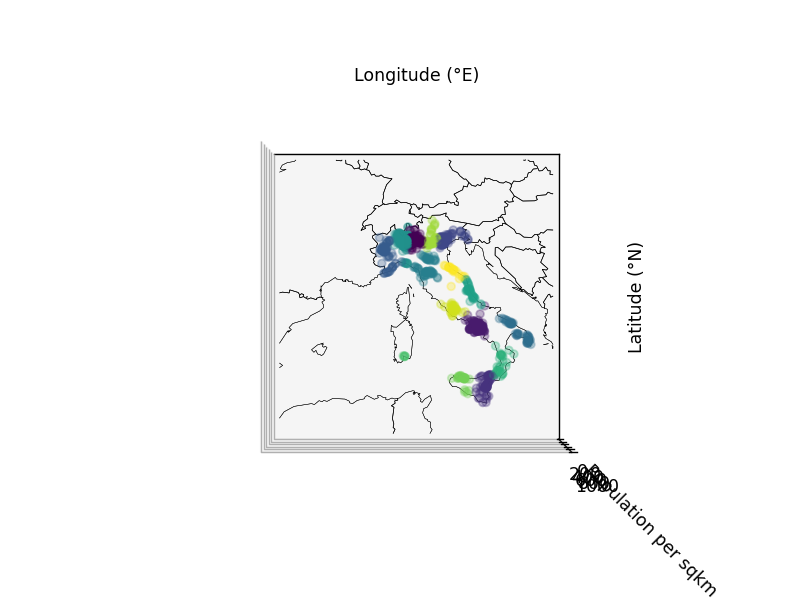

In [10]:
from scipy.spatial.distance import cdist

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

llcrnrlat = 35
urcrnrlat = 50
llcrnrlon = 0
urcrnrlon = 20
# Create a basemap instance that draws the Earth layer
bm = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon, 
            urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
             projection='cyl', resolution='l', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=-90, elev=90)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population per sqkm ', labelpad=20)
# Add meridian and parallel gridlines*
# lon_step = 0.5
# lat_step = 0.5
# meridians = np.arange(7, 12 + lon_step, lon_step)
# parallels = np.arange(44, 47 + lat_step, lat_step)
# ax.set_yticks(parallels)
# ax.set_yticklabels(parallels)
# ax.set_xticks(meridians)
# ax.set_xticklabels(meridians)
ax.set_zlim(0., 1000)

categories = clustering.labels_
colormap = np.arange(0,15)
p = ax.scatter(lon, lat, (populationsqm), c=colormap[categories])
plt.show()

In [11]:
import pyproj
import json
from shapely.geometry import Point, mapping
from functools import partial
from shapely.ops import transform

def kmRadius(c): #Define area of attractiveness
    point = Point(c)
    
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(20_000)#Meters

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)
    dic = mapping(buffer_wgs84)
    return np.asarray(dic['coordinates'])[0]

## 3D map Lombardy

<IPython.core.display.Javascript object>


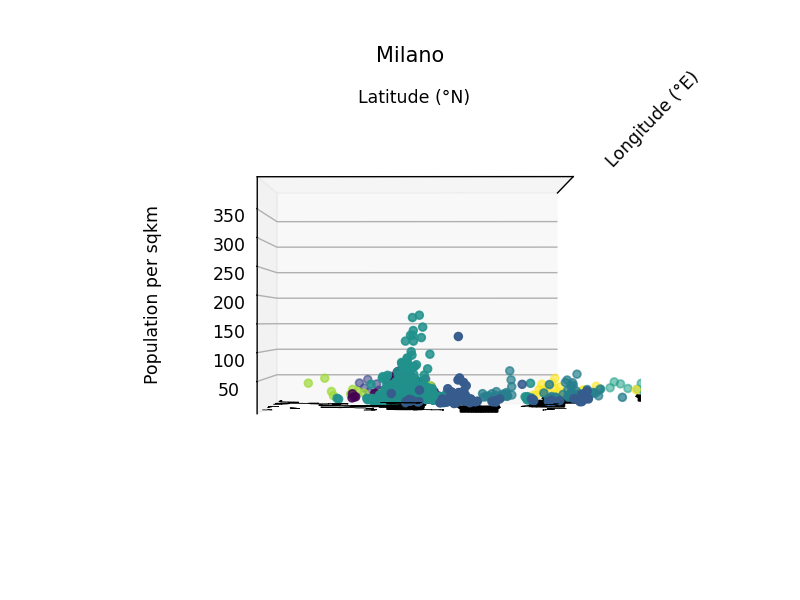

In [39]:
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


llcrnrlat = 44
urcrnrlat = 47
llcrnrlon = 7
urcrnrlon = 12
# Create a basemap instance that draws the Earth layer
bm = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon, 
            urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
             projection='cyl', resolution='h', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=-90, elev=90)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population per sqkm', labelpad=20)
ax.set_zlim(0., 400)

cluster_colors = np.array(['green','blue','red'])
categories = clustering.labels_


colormap = np.arange(0,15)
C = ss.inverse_transform(km.cluster_centers_)#Centroids
p = ax.scatter(lon, lat, (populationsqm), c=colormap[categories], picker = True)#Points
centers = ax.scatter(xs=C[:,0], ys=C[:,1], edgecolor='black', c='white', marker = '*')#Centers

r = []
for c in C:
    circle = kmRadius(c)
    r.append(ax.scatter(xs=circle[:,0], ys=circle[:,1], c='black', marker = '1'))#Radius

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def getxyz(event):
    s = ax.format_coord(event.xdata, event.ydata)
    try:
        out = [float(x.split('=')[1].strip()) for x in s.split(',')]
    except:
        out = None
    return out

def onclick(event): #Need to zoom  a bit for it to work (????), click on top right corner
    out = getxyz(event)
    if out != None:
        az = ax.azim
        el = ax.elev
        if (abs(el) <= 2): #If elevation 0
            if (abs(az) <= 2 or abs(abs(az) -180) <= 2): # get z and not x
                zPt = out[2]
                latPt = out[1]
                closest = closest_point((zPt/100,latPt), list(zip(populationsqm/100, lat)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["lat"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            elif (abs(az)-90 <= 2):# get z and not y
                zPt = out[2]
                lonPt = out[0]
                tx = out[0]
                closest = closest_point((zPt/100,lonPt), list(zip(populationsqm/100, lon)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["lng"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            else:
                ax.set_title("Please adjust azimuth")
        elif (abs(el-90) <= 2):
            lonPt = out[0]#llcrnrlon+(urcrnrlon-llcrnrlon)/2 + event.xdata*((urcrnrlon-llcrnrlon)/2)/0.05481
            latPt = out[1]#llcrnrlat+(urcrnrlat-llcrnrlat)/2 + event.ydata*((urcrnrlat-llcrnrlat)/2)/0.05481
            closest = closest_point((lonPt,latPt), list(zip(lon, lat)))#Get closest point from picked
            tx = '%s' % (df.loc[(df["lng"] == closest[0])&
                                (df["lat"] == closest[1])]["Territorio"].values[0])
            ax.set_title(tx)
        else:
            ax.set_title("Please adjust elevation")
    
# def on_lims_change(axes):
#     global llcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon
#     llcrnrlat = ax.get_ylim()[0]
#     urcrnrlat = ax.get_ylim()[1]
#     llcrnrlon = ax.get_xlim()[0]
#     urcrnrlon = ax.get_xlim()[1]

cid = fig.canvas.mpl_connect('button_press_event', onclick)#Get mouse click
#fig.canvas.mpl_connect('button_release_event', saveRotation)#Get mouse release

#ax.callbacks.connect('xlim_changed', on_lims_change)#Get zoom

fig.show()

## Elbow

In [26]:
# from scipy.spatial.distance import cdist

# distortions = []
# inertias = []
# mapping1 = {}
# mapping2 = {}
# K = range(2, 20)
 
# for k in K:
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
 
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                         'euclidean'), axis=1)) / X.shape[0])
#     inertias.append(kmeanModel.inertia_)
 
#     mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                    'euclidean'), axis=1)) / X.shape[0]
#     mapping2[k] = kmeanModel.inertia_

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()

## Add transport (trains)

### Regionals

In [63]:
stops = pd.read_csv("new/Orario_Ferroviario_Regionale_-_Stops.csv")
stops= stops.drop(["stop_code","stop_id", "stop_desc", "stop_url", "location_type", "parent_station","location"],axis = 1)
stops

,stop_name,stop_lat,stop_lon
0,MOTTA S.DAMIANO,45.178212,9.221850
1,BOVISIO MASCIAGO-MOMBELLO,45.612041,9.141317
2,VAREDO,45.595605,9.153331
3,ORIO LITTA,45.166951,9.550633
4,BISUSCHIO-VIGGIU',45.870643,8.887910
...,...,...,...
422,LESA,45.825542,8.558806
423,MILANO ROMOLO,45.443351,9.167479
424,NOVARA FN,45.452082,8.626435
425,GALLIATE,45.481122,8.691409


In [64]:
from geopy import distance
from geopy import Point

def cutAwayMoreThanMinutes(stops):
#     avgTrainSpeed = 45 #km/h 
    #Remove if more than 1.5h
    #Remove from Colico and from Iseo
    point = stops.loc[stops["stop_name"] == "COLICO"]
    stops = stops.drop(stops[stops["stop_lat"] > point["stop_lat"].values[0]].index)#Prata Camportaccio
    stops = stops.drop(stops[(stops["stop_lat"] > point["stop_lat"].values[0]-0.1) & 
                       (stops["stop_lon"] > point["stop_lon"].values[0])].index)#Tirano
    point = stops.loc[stops["stop_name"] == "ISEO"]
    stops = stops.drop(stops[(stops["stop_lat"] > point["stop_lat"].values[0]) & 
                       (stops["stop_lon"] > point["stop_lon"].values[0])].index)#Cedegolo
    return stops


<IPython.core.display.Javascript object>


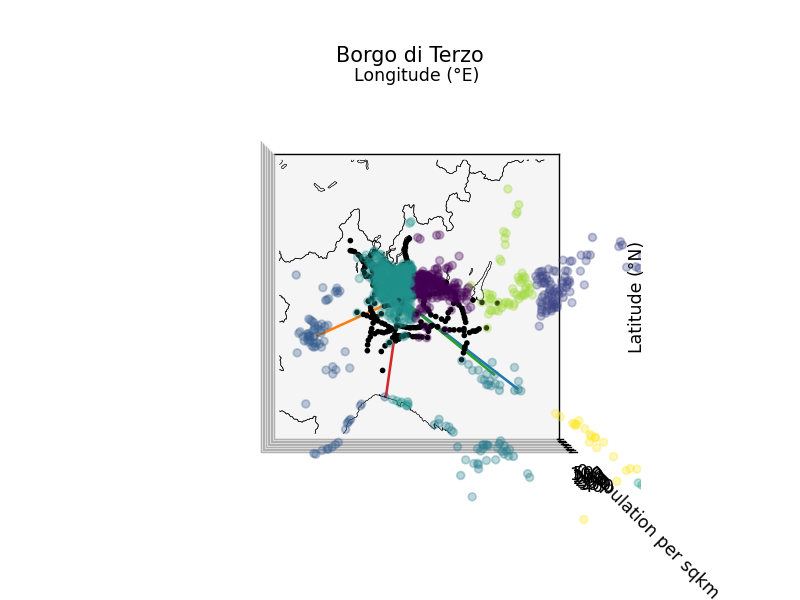

In [65]:
stops = cutAwayMoreThanMinutes(stops)
p = ax.scatter(xs=stops["stop_lon"], ys=stops["stop_lat"],marker = '.', c = "Black")#Centers
display(fig)  # Shows plot again

for radius in r:
    radius.remove()
centers.remove()

## High speed

In [66]:
hs = pd.read_csv("new/Orario_Ferroviario_Frecce.csv")
hs

,stop_name,stop_lat,stop_lon
0,Bologna,44.494887,11.342616
1,Torino,45.070312,7.686857
2,Modena,44.648837,10.920087
3,Genova,44.405650,8.946256


<IPython.core.display.Javascript object>


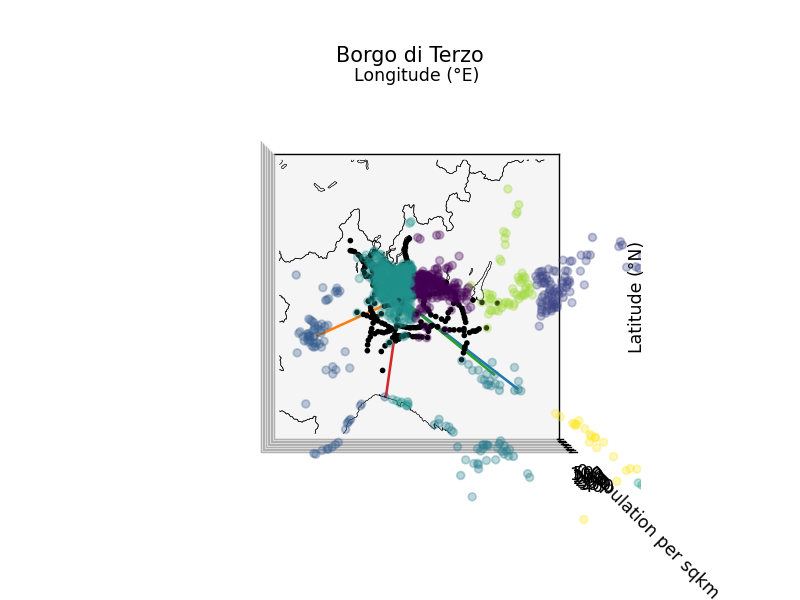

In [67]:
milano = stops.loc[stops["stop_name"] =="MILANO CENTRALE"]
for index, row in hs.iterrows():
    ax.plot([row["stop_lon"],milano["stop_lon"].values[0]], [row["stop_lat"],milano["stop_lat"].values[0]])

display(fig)  # Shows plot again
